# Spam Detection 
## A Binary Classification Approach 


##  Overview
This notebook focuses on **spam detection in text messages** using **machine learning models**.  
The goal is to classify messages as **Spam (1) or Not Spam (0)** based on their content.

## 🔹 Models Used
This notebook evaluates two different models for spam classification:
 **Naïve Bayes (MultinomialNB)** – A popular model for text classification.  
 **Logistic Regression** – A strong baseline model for binary classification.  

## 🔹 Key Steps
- 📊 **Exploratory Data Analysis (EDA)**
- 📝 **Text Preprocessing (Cleaning, Tokenization, TF-IDF)**
- 🏗 **Building & Training Machine Learning Models**
- 📈 **Evaluating Model Performance (Accuracy, Precision, Recall, F1-Score)**
- 🔧 **Hyperparameter Tuning for Better Performance**




<br>

## Exploratory Data Analysis 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# load data set 
df = pd.read_csv("SMSSpamCollection", sep="\t", header=None, names=["label", "message"])


In [3]:
df.head(10)

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
5,spam,FreeMsg Hey there darling it's been 3 week's n...
6,ham,Even my brother is not like to speak with me. ...
7,ham,As per your request 'Melle Melle (Oru Minnamin...
8,spam,WINNER!! As a valued network customer you have...
9,spam,Had your mobile 11 months or more? U R entitle...


In [4]:
df.shape

(5572, 2)

In [5]:
# check null values & data types
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   label    5572 non-null   object
 1   message  5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB




 label
ham     4825
spam     747
Name: count, dtype: int64 


------------------------------------------------------------------------------------------------------------------------


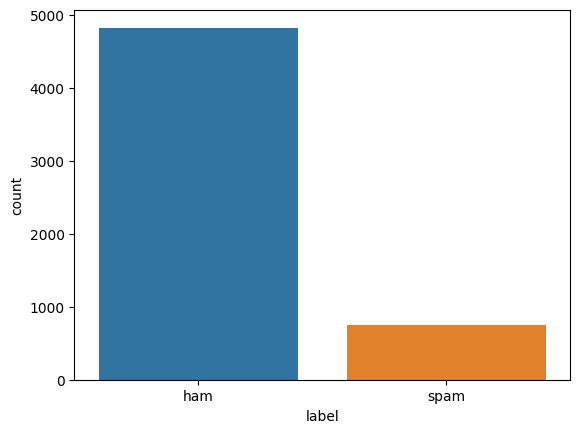

In [6]:
# check label ( spam & ham )  frequency 
print("\n\n", df.value_counts("label"),"\n\n")
print("--"*60)
sns.countplot(data=df, x="label", hue="label")
plt.show()


In [7]:
# Convert target data ( Label ) to numeric feature
# Map labels and Assign spam = 1 , ham = 0 

df["label"]=df["label"].map({"spam":1 , "ham":0})

In [8]:
# Check label data type again
df["label"].dtypes

dtype('int64')

In [9]:
# Clean message contents from extra space, numbers and punctuations

import re

def clean_txt(text):
    text=text.lower() # lower case 
    text = re.sub(r"[^\w\s]", " ", text)    # Remove all punctuations
    text = re.sub(r"\d+", " ", text)        # Remove numbers
    text = " ".join(text.split())           # Remove extra spaces
    return text          
df['cleaned_message'] = df['message'].apply(clean_txt)    

In [10]:
# print samples after cleaning the messages 
print(df['cleaned_message'].sample(5))

5511                  it s reassuring in this crazy world
5301                  at what time should i come tomorrow
2070    eerie nokia tones u rply tone title to eg tone...
3927                             i havent add ü yet right
3477    i can probably come by everybody s done around...
Name: cleaned_message, dtype: object


<br>

In [11]:
# Summarizing messaage content 
# Message length descriptive statistics of message length based on labels 
df["clean_message_length"]=df['cleaned_message'].apply(len)
df[["label","clean_message_length"]].groupby('label').describe()

clean_message_length                                                   \
                     count        mean        std  min    25%    50%    75%   
label                                                                         
0                   4825.0   67.381554  55.242186  0.0   31.0   50.0   88.0   
1                    747.0  115.760375  26.447837  4.0  106.0  123.0  132.0   

              
         max  
label         
0      907.0  
1      182.0

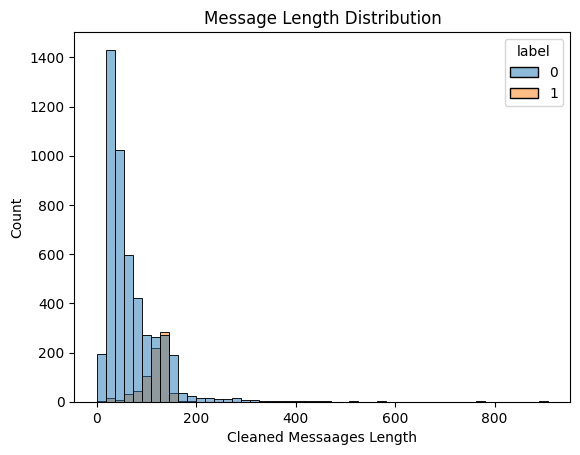

In [12]:
# Visualization : Message Length Distribution for both labels 
sns.histplot(df, x=df["clean_message_length"], bins=50, hue="label")
plt.xlabel("Cleaned Messaages Length")
plt.title("Message Length Distribution")
plt.show()

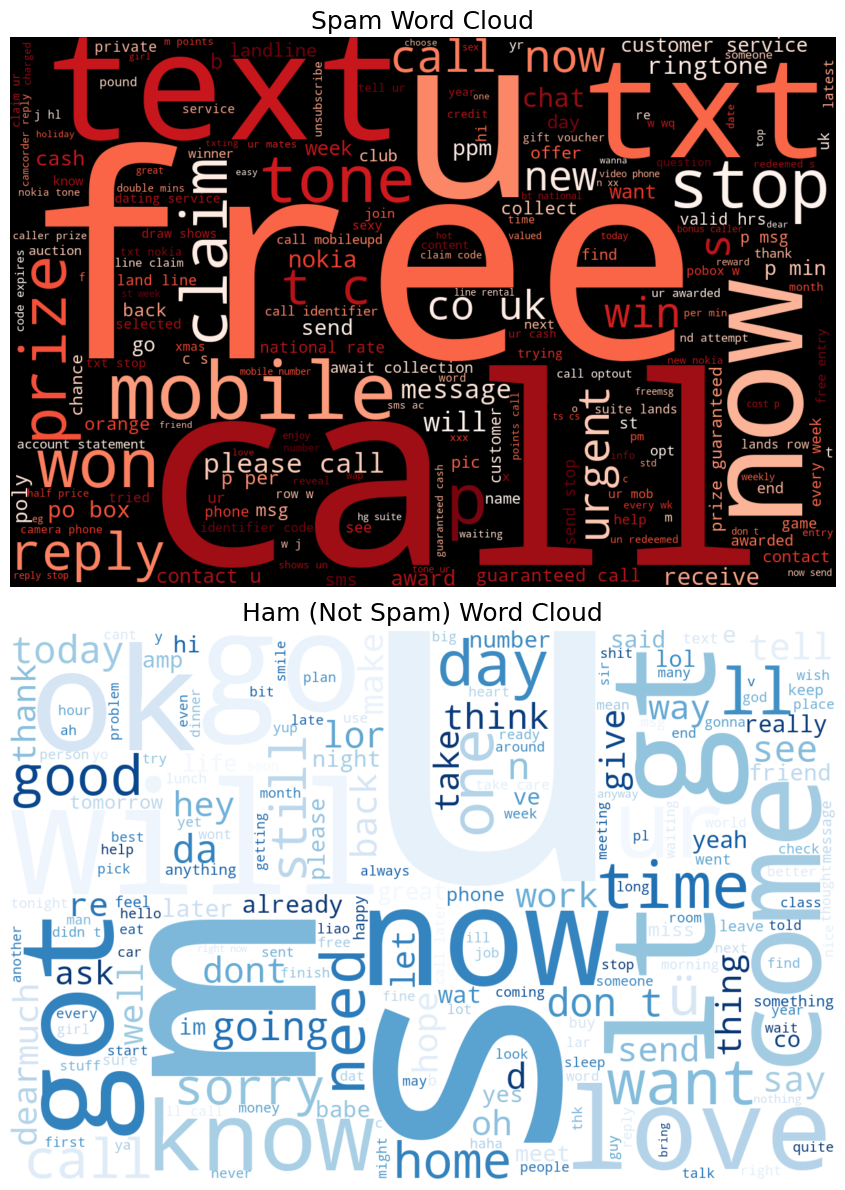

In [29]:
# Freq words in spam and non spam message content 
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Separate spam and ham messages
spam_text = " ".join(df[df['label'] == 1]['cleaned_message'])
ham_text = " ".join(df[df['label'] == 0]['cleaned_message'])

# Generate Word Clouds with Larger Dimensions
spam_wc = WordCloud(width=1200, height=800, background_color='black', colormap='Reds').generate(spam_text)
ham_wc = WordCloud(width=1200, height=800, background_color='white', colormap='Blues').generate(ham_text)

# Create a Larger Figure with Two Rows
plt.figure(figsize=(12,12))  

# Plot Spam Word Cloud
plt.subplot(2,1,1)  # Two rows, one column, first plot
plt.imshow(spam_wc, interpolation="bilinear")
plt.axis("off")
plt.title("Spam Word Cloud", fontsize=18)

# Plot Ham Word Cloud
plt.subplot(2,1,2)  # Two rows, one column, second plot
plt.imshow(ham_wc, interpolation="bilinear")
plt.axis("off")
plt.title("Ham (Not Spam) Word Cloud", fontsize=18)

# Show the plots
plt.tight_layout()
plt.show()


<br>

## Key insights from EDA

✅ The **Average length of spam messages** (115.76 characters) is almost **twice as long as non-spam messages** (67.38 characters)

The median (50th percentile) for spam (123 characters) is also much higher than for non-spam (50 characters)

✅ **Spam** message lengths are **tightly concentrated** between 106 - 132 characters (IQR)

✅  **The standard deviation** (26.44) of spam messages is much lower than that of non-spam messages (55.24), meaning spam messages tend to have similar lengths. highly likely due to Many spam messages follow a specific structure pre-written templates

✅  Most non-spam messages are shorter than 100 characters, The **peak is around 50 characters**

✅  Spam messages show a clear **peak around 120-140 characters** suggests a consistent length pattern

<br><br>

## Text Feature Extraction (TF-IDF ) 

In [14]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Initialize TF-IDF Vectorizer
tfidf = TfidfVectorizer(stop_words='english', max_features=3000)  # Limit features to top 3000 words
X = tfidf.fit_transform(df['cleaned_message'])

In [15]:
# split data into training and test
y=df["label"]
from sklearn.model_selection import train_test_split

# Split dataset (80% Train, 20% Test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

## Building Classifier Models (Logistic Regression, Naïve Bayes)

In [16]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics

In [17]:
# Building a Logistic Regression model
clf = LogisticRegression(penalty='l2')
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

cm = metrics.confusion_matrix(y_test, y_pred)
acc = metrics.accuracy_score(y_test, y_pred)
pre = metrics.precision_score(y_test, y_pred)
rec = metrics.recall_score(y_test, y_pred)
f1 = metrics.f1_score(y_test, y_pred)
print('--'*50)
print(cm,'        ',np.round(acc,4),'           ',np.round(pre,4),'               ',np.round(rec,4),'          ',np.round(f1,4))
print('confusion matrix,  accurac,           precision,          recall,           F1 score')
print('--'*50)

----------------------------------------------------------------------------------------------------
[[965   1]
 [ 34 115]]          0.9686             0.9914                 0.7718            0.8679
confusion matrix,  accurac,           precision,          recall,           F1 score
----------------------------------------------------------------------------------------------------


In [18]:
# Building a  Naïve Bayes model
clf = MultinomialNB()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

cm = metrics.confusion_matrix(y_test, y_pred)
acc = metrics.accuracy_score(y_test, y_pred)
pre = metrics.precision_score(y_test, y_pred)
rec = metrics.recall_score(y_test, y_pred)
f1 = metrics.f1_score(y_test, y_pred)

print('--'*50)
print(cm,'        ',np.round(acc,4),'           ',np.round(pre,4),'               ',np.round(rec,4),'          ',np.round(f1,4))
print('confusion matrix,  accuracy,          precision,          recall,           F1 score')
print('--'*50)

----------------------------------------------------------------------------------------------------
[[966   0]
 [ 27 122]]          0.9758             1.0                 0.8188            0.9004
confusion matrix,  accuracy,          precision,          recall,           F1 score
----------------------------------------------------------------------------------------------------


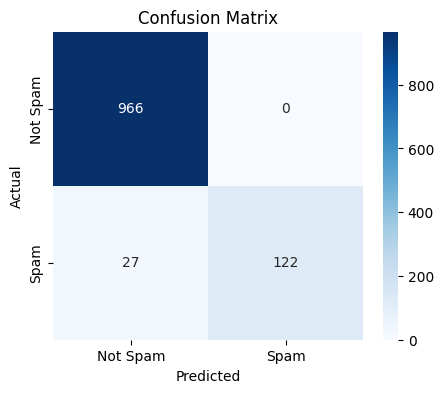

In [19]:
# Plot Confusion Matrix
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=["Not Spam", "Spam"], yticklabels=["Not Spam", "Spam"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

### Result explaination : 

✅ **Naïve Bayes’ perfect precision**, meaning it never misclassifies a non-spam as spam!

Naïve Bayes assumes word independence and uses word probabilities, making it work exceptionally well with sparse data 

like TF-IDF. Result: It performs well in spam detection

Naïve Bayes, handles class imbalance better by relying on word probabilities

<br>

## Hyperparameter Tuning

In [20]:
from sklearn.model_selection import GridSearchCV

# Define hyperparameter grid
param_grid = {'alpha': [0.1, 0.5, 1.0, 2.0, 5.0]}

# Grid search with cross-validation
grid_search = GridSearchCV(MultinomialNB(), param_grid, scoring='recall', cv=5)
grid_search.fit(X_train, y_train)

# Best alpha value
print(f"Best alpha for recall: {grid_search.best_params_['alpha']}")

# Train Naïve Bayes with best alpha
best_clf = MultinomialNB(alpha=grid_search.best_params_['alpha'])
best_clf.fit(X_train, y_train)

# Evaluate again
y_pred = best_clf.predict(X_test)
rec = metrics.recall_score(y_test, y_pred)
print(f"Updated Recall: {np.round(rec, 4)}")


Best alpha for recall: 0.1
Updated Recall: 0.8993


In [21]:
# Building a  Naïve Bayes model
clf = MultinomialNB(alpha=0.1)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

cm = metrics.confusion_matrix(y_test, y_pred)
acc = metrics.accuracy_score(y_test, y_pred)
pre = metrics.precision_score(y_test, y_pred)
rec = metrics.recall_score(y_test, y_pred)
f1 = metrics.f1_score(y_test, y_pred)

print('--'*50)
print(cm,'        ',np.round(acc,4),'           ',np.round(pre,4),'               ',np.round(rec,4),'          ',np.round(f1,4))
print('confusion matrix,  accuracy,          precision,          recall,           F1 score')
print('--'*50)

----------------------------------------------------------------------------------------------------
[[963   3]
 [ 15 134]]          0.9839             0.9781                 0.8993            0.9371
confusion matrix,  accuracy,          precision,          recall,           F1 score
----------------------------------------------------------------------------------------------------


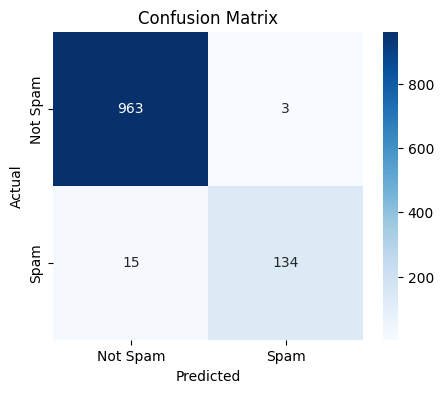

In [22]:
# Plot Confusion Matrix
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=["Not Spam", "Spam"], yticklabels=["Not Spam", "Spam"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

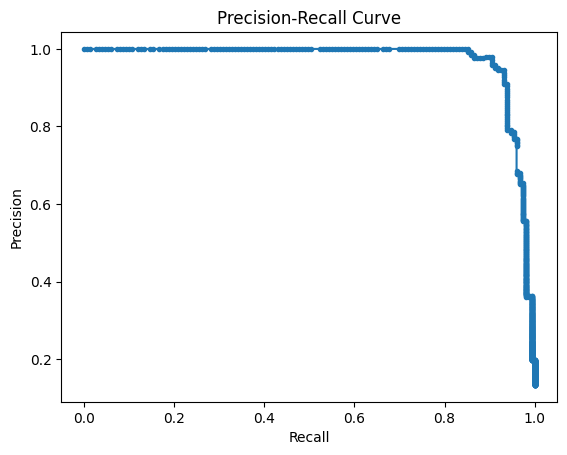

In [23]:
from sklearn.metrics import precision_recall_curve, roc_curve

# Get probabilities
y_pred_probs = clf.predict_proba(X_test)[:, 1]

# Precision-Recall Curve
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_probs)
plt.plot(recall, precision, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()


In [24]:
import numpy as np

# Get probability predictions
y_pred_probs = clf.predict_proba(X_test)[:, 1]  # Get spam probabilities

# Set an optimal threshold (e.g., 0.4 instead of 0.5)
optimal_threshold = 0.4
y_pred_adjusted = (y_pred_probs > optimal_threshold).astype(int)

# Evaluate new precision & recall
from sklearn.metrics import precision_score, recall_score, f1_score

pre_adjusted = precision_score(y_test, y_pred_adjusted)
rec_adjusted = recall_score(y_test, y_pred_adjusted)
f1_adjusted = f1_score(y_test, y_pred_adjusted)

print(f"Adjusted Threshold: {optimal_threshold}")
print(f"New Precision: {np.round(pre_adjusted, 4)}")
print(f"New Recall: {np.round(rec_adjusted, 4)}")
print(f"New F1 Score: {np.round(f1_adjusted, 4)}")


Adjusted Threshold: 0.4
New Precision: 0.9577
New Recall: 0.9128
New F1 Score: 0.9347


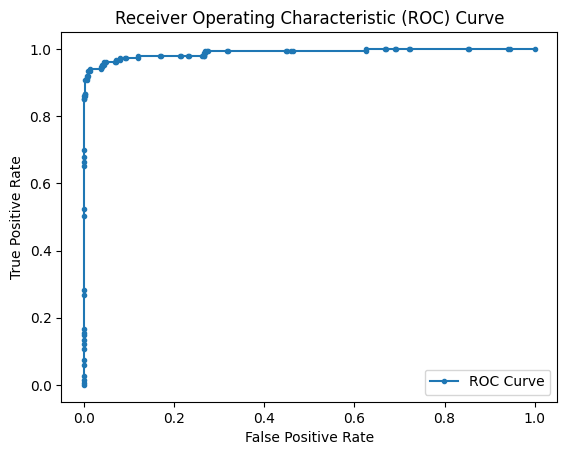

In [25]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

fpr, tpr, thresholds = roc_curve(y_test, y_pred_probs)

plt.plot(fpr, tpr, marker='.', label="ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend()
plt.show()


# 📌 Hyperparameter Tuning for Spam Detection  

## Optimizing `alpha` in Naïve Bayes to Improve **recall** without a significant drop in precision
  
- Naïve Bayes has a smoothing parameter **`alpha`** that controls word probabilities.
- **Lower `alpha` (e.g., 0.1, 0.3)** → Detects more spam (**higher recall**).

**✅ Result:**  
- Best value found: `alpha = 0.1`  
- Recall **increased**, but precision dropped slightly.  
- To maintain **precision**, additional tuning is required.

---

## **Adjusting Decision Threshold to find the best trade-off between **precision & recall****  
 
- By default, **Naïve Bayes predicts spam if `P(spam) > 0.5`**.
- **Lowering the threshold (e.g., `0.4`)** → Increases recall, detecting more spam.
- **Increasing the threshold (e.g., `0.6`)** → Reduces false positives, improving precision.

**✅ Process:**  
- Used **Precision-Recall Curve** to visualize the trade-off.  
- Adjusted threshold to **maximize recall without hurting precision too much**.

**✅ Final Outcome:**  
- **Higher recall (spam detection improved).**  
- **Minimal loss in precision (false alarms under control).**  
- **Balanced F1-score → Best overall spam classification.**  